 # Monte Carlo study of Doubly-Robust Estimators for Average Treatment Effects under model misspecification

 What this notebook does:
 - Simulates treatment/outcome data from two DGPs:
   * Homogeneous ATE: constant effect; non-linear propensity in X1; outcome non-linear in X2.
   * Heterogeneous ATE: effect varies with X1; same propensity/outcome structure.
 - Fits nuisance models:
   * Propensity: logistic (correct vs misspecified by omitting X1^2).
   * Outcome: OLS fit separately on D=0 and D=1 (correct vs misspecified by omitting X2^2).
 - Computes estimators:
   * Outcome Regression (OR).
   * Inverse Probability Weighting (IPW).
   * Doubly-Robust Estimator (DR).
 - Repeats over N_SIMULATIONS in parallel and aggregates per estimator:
   * Absolute Bias
   * Std. Error
 - Caches summaries to CSV (one per analysis). If CSV exists, plots are made
   without re-running simulations; otherwise simulations run and CSVs are saved.
 - Plots bar charts.

 Key configs:
 - N_SIMULATIONS, N_SAMPLES, TRUE_ATE.
 - Results are rounded to 3 decimals for display; CSVs keep full precision.

Running simulations (heterogeneous=True): 100%|██████████| 1000/1000 [00:40<00:00, 24.82it/s]


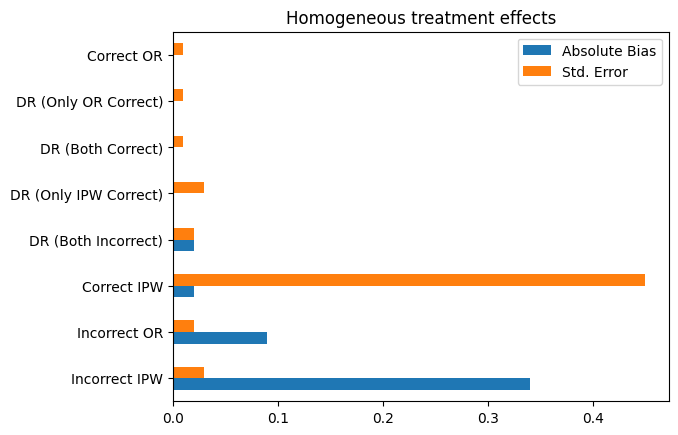

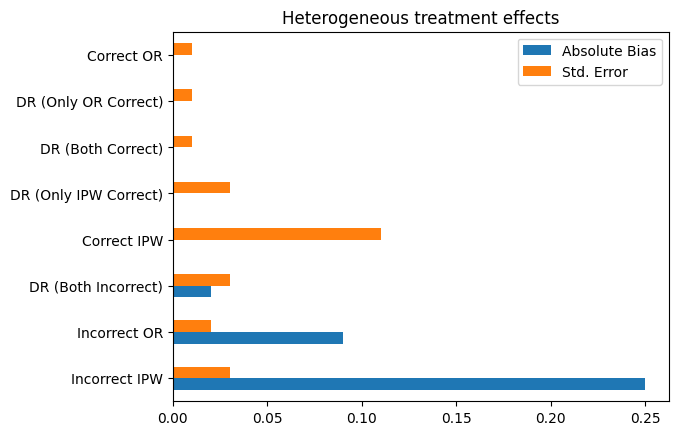

In [6]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from joblib import Parallel, delayed
import os
from tqdm_joblib import tqdm_joblib

# --- 1. GLOBAL CONFIGURATION ---
N_SIMULATIONS = 1000
N_SAMPLES = 100000
TRUE_ATE = 5.0

# --- DATA GENERATING PROCESSES ---

def generate_homogeneous_data(n_samples=N_SAMPLES, ate=TRUE_ATE):
    """Generates data where the treatment effect is constant."""
    X1 = np.random.normal(0, 1, n_samples)
    X2 = np.random.normal(0, 1, n_samples)
    X1_sq = X1**2
    X2_sq = X2**2

    # True propensity model is non-linear in X1
    true_propensity = 1 / (1 + np.exp(-(0.5 * X1 + 0.5 * X2 + 0.5 * X1_sq)))
    D = np.random.binomial(1, true_propensity)

    # True outcome model is non-linear in X2, with a constant ATE
    noise = np.random.normal(0, 1, n_samples)
    Y = 10 + 2 * X1 + 3 * X2 + 2 * X2_sq + (ate * D) + noise

    return pd.DataFrame({
        'X1': X1, 'X2': X2, 'X1_sq': X1_sq, 'X2_sq': X2_sq, 'D': D, 'Y': Y
    })

def generate_heterogeneous_data(n_samples=N_SAMPLES, base_ate=TRUE_ATE):
    """Generates data where the treatment effect depends on X1."""
    X1 = np.random.normal(0, 1, n_samples)
    X2 = np.random.normal(0, 1, n_samples)
    X1_sq = X1**2
    X2_sq = X2**2

    # True propensity model is non-linear in X1
    true_propensity = 1 / (1 + np.exp(-(0.5 * X1 + 0.5 * X2 + 0.5 * X1_sq)))
    D = np.random.binomial(1, true_propensity)

    # True outcome model is non-linear in X2, with a CATE dependent on X1
    cate = base_ate + 2 * X1
    noise = np.random.normal(0, 1, n_samples)
    Y = 10 + 2 * X1 + 3 * X2 + 2 * X2_sq + (cate * D) + noise

    return pd.DataFrame({
        'X1': X1, 'X2': X2, 'X1_sq': X1_sq, 'X2_sq': X2_sq, 'D': D, 'Y': Y
    })


# --- NUISANCE MODELS ---

def fit_propensity_model(data, misspecified=False):
    """Fits the propensity score model."""
    formula = "D ~ X1 + X2" if misspecified else "D ~ X1 + X2 + X1_sq"
    model = smf.logit(formula, data=data).fit(disp=0)
    return model.predict(data)

def fit_outcome_models(data, misspecified=False, heterogeneous=False):
    """Fits outcome models for treated and control groups."""
    if misspecified:
        formula = "Y ~ X1 + X2"
    else:
        formula = "Y ~ X1 + X2 + X2_sq"
        if heterogeneous:
            formula += " + D:X1" # Use interaction form for single model

    # For OR, it's cleaner to fit separate models
    formula_or = formula.replace("D:X1", "X1") # remove interaction syntax for subgroup model
    
    model_0 = smf.ols(formula_or, data=data[data['D'] == 0]).fit()
    model_1 = smf.ols(formula_or, data=data[data['D'] == 1]).fit()

    mu0_hat = model_0.predict(data)
    mu1_hat = model_1.predict(data)
    return mu0_hat, mu1_hat


# --- ESTIMATORS ---

def estimate_or(mu1_hat, mu0_hat):
    """Outcome Regression estimator."""
    return np.mean(mu1_hat - mu0_hat)

def estimate_ipw(data, pi_hat):
    """Inverse Probability Weighting estimator."""
    return np.mean(data['D'] * data['Y'] / pi_hat - (1 - data['D']) * data['Y'] / (1 - pi_hat))

def estimate_dr(data, pi_hat, mu0_hat, mu1_hat):
    """Doubly Robust estimator."""
    pi_hat = np.clip(pi_hat, 0.01, 0.99)
    term1 = data['D'] * (data['Y'] - mu1_hat) / pi_hat + mu1_hat
    term2 = (1 - data['D']) * (data['Y'] - mu0_hat) / (1 - pi_hat) + mu0_hat
    return np.mean(term1 - term2)

# --- MAIN SIMULATION ---

def run_single_simulation(dgp_function, heterogeneous_flag):
    """Runs one iteration of the simulation."""
    df = dgp_function()
    
    pi_correct = fit_propensity_model(df, misspecified=False)
    pi_incorrect = fit_propensity_model(df, misspecified=True)
    
    mu0_correct, mu1_correct = fit_outcome_models(df, misspecified=False, heterogeneous=heterogeneous_flag)
    mu0_incorrect, mu1_incorrect = fit_outcome_models(df, misspecified=True, heterogeneous=heterogeneous_flag)
    
    estimates = {
        'DR (Both Correct)': estimate_dr(df, pi_correct, mu0_correct, mu1_correct),
        'DR (Only IPW Correct)': estimate_dr(df, pi_correct, mu0_incorrect, mu1_incorrect),
        'DR (Only OR Correct)': estimate_dr(df, pi_incorrect, mu0_correct, mu1_correct),
        'DR (Both Incorrect)': estimate_dr(df, pi_incorrect, mu0_incorrect, mu1_incorrect),
        'Correct OR': estimate_or(mu1_correct, mu0_correct),
        'Incorrect OR': estimate_or(mu1_incorrect, mu0_incorrect),
        'Correct IPW': estimate_ipw(df, pi_correct),
        'Incorrect IPW': estimate_ipw(df, pi_incorrect),
    }
    return estimates

def run_parallel_simulation(dgp_function, heterogeneous_flag):
    """Runs the full simulation in parallel."""
    with tqdm_joblib(desc=f"Running simulations (heterogeneous={heterogeneous_flag})", total=N_SIMULATIONS):
        results = Parallel(n_jobs=-1)(
            delayed(run_single_simulation)(dgp_function, heterogeneous_flag)
            for _ in range(N_SIMULATIONS)
        )
        
    results_df = pd.DataFrame(results)
    summary = pd.DataFrame({
        'Absolute Bias': abs(results_df.mean() - TRUE_ATE),
        'Std. Error': results_df.std()
    })
    return summary.round(2)

# --- EXECUTION ---

if __name__ == "__main__":
    homogeneous_csv = "homogeneous_summary.csv"
    if os.path.exists(homogeneous_csv):
        homogeneous_results = pd.read_csv(homogeneous_csv, index_col=0)
    else:
        homogeneous_results = run_parallel_simulation(generate_homogeneous_data, heterogeneous_flag=False)
        homogeneous_results.to_csv(homogeneous_csv, index=True)
    homogeneous_results[['Absolute Bias', 'Std. Error']].sort_values(['Absolute Bias', 'Std. Error'], ascending=[False, False]).plot.barh(title='Homogeneous treatment effects')

    heterogeneous_csv = "heterogeneous_summary.csv"
    if os.path.exists(heterogeneous_csv):
        heterogeneous_results = pd.read_csv(heterogeneous_csv, index_col=0)
    else:
        heterogeneous_results = run_parallel_simulation(generate_heterogeneous_data, heterogeneous_flag=True)
        heterogeneous_results.to_csv(heterogeneous_csv, index=True)
    heterogeneous_results[['Absolute Bias', 'Std. Error']].sort_values(['Absolute Bias', 'Std. Error'], ascending=[False, False]).plot.barh(title='Heterogeneous treatment effects')